## Overview

In this notebook, we will focus on using Gradient Boosted Trees (in particular XGBoost) to classify a theoretical model with new Higgs bosons, described by [Baldi et al. Nature Communication 2015 and Arxiv:1402.4735](https://arxiv.org/pdf/1402.4735.pdf]). 
The data set consists of 11M Monte-Carlo samples of signal (gluon fusion producing $gg \rightarrow H^{0} \rightarrow W^{\pm} H^{\mp} \rightarrow W^{\pm} W^{\mp} h^{0} \rightarrow W^{\pm} W^{\mp} b\bar{b}$, with $M_{h^{0}} \sim$ 125.3 GeV, $M_{W} \sim$ 80.4 GeV) and background (top-quarks $gg \rightarrow  t\bar{t} \rightarrow W^{+} W^{-} b\bar{b}$) with 21 features. 
<br />
<br />
Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
<br />
Description: https://archive.ics.uci.edu/ml/datasets/HIGGS 
<!--- See also Yandex https://colab.research.google.com/github/yandexdataschool/mlhep2019/blob/master/notebooks/day-2/02_decision_trees_and_ensembles.ipynb
--->


<!---
![signal (a) VS background (b)](./images/higgs_dataset.png)
--->

<img src="./images/higgs_dataset.png" alt="drawing" width="400"/>

Simulated events are generated with MADGRAPH event generator assuming 8 TeV collisions of protons at LHC, with showering and hadronization performed by PYTHIA and detector response simulated by DELPHES. 
We assume as benchmark case $m_{H^{0}} =$ 425 GeV and $m_{H^{\pm}} =$ 325 GeV. 

We focus on the semi-leptonic decay mode, in which **only one W boson decays to a lepton and neutrino ($l \nu$), and the other decays to a pair of jets ($jj$)**, giving the decay product **$l\nu jj b \bar{b}$**.


We consider data with:

- Exactly one electron or muon, with $p_{T} >$ 20 GeV and $|\eta| <$ 2.5;

- at least four jets, each with $p_{T} >$ 20 GeV GeV and $|\eta| <$ 2.5;

- b-tags on at least two of the jets, indicating that they are likely due to b-quarks rather than gluons or lighter quarks


In addition we reconstruct the missing transverse momentum in the event and have b-tagging information for each jet. Together, 21 features comprise our low-level feature set.

The low-level features show some distinguishing characteristics, but our knowledge of the different interme- diate states of the two processes allows us to construct other features which better capture the differences.

We can also check the reconstruction of the invariant mass of:

- $W \rightarrow l\nu$ gives a peak in the $M_{l\nu}$ distribution at the known $W$ boson mass, $M_{W}$ ,

- $W \rightarrow jj$ gives a peak in the $M_{jj}$ distribution at $M_{W}$,

- $h^{0} \rightarrow b\bar{b}$ gives a peak in the $M_{b\bar{b}}$ distribution at the known Higgs boson mass, $M_{h^{0}}$ ,

- $H^{\pm} \rightarrow Wh^{0}$ gives a peak in the $M_{Wb\bar{b}}$ distribution at the assumed $H^{\pm}$ mass, $M_{H^{\pm}}$ ,

- $H^{0} \rightarrow WH^{\pm}$ gives a peak in the $M_{WW b \bar{b}}$ distribution at the assumed $H^{0}$ mass,at $M_{H^{0}}$


Note that the leptonic W boson is reconstructed by combining the lepton with neutrino, whose transverse momentum is deduced from the imbalance of momentum in the final state objects and whose rapidity is set to give $M_{l\nu}$ closest to $M_{W} =$ 80.4 GeV.

In the case of the $t\bar{t}$ background, we expect:

- $W \rightarrow l \nu$ gives a peak at $M_{W}$

- $W \rightarrow jj$ gives a peak at $M_{W}$ 

- $t \rightarrow Wb$ gives a peak in $M_{l\nu b}$ and $M_{jj b}$ at $M_{t}$


The first column is the class label (1 for signal, 0 for background), followed by the 28 features (21 low-level features then 7 high-level features): lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb. 
</br>
For more detailed information about each feature see the original paper.


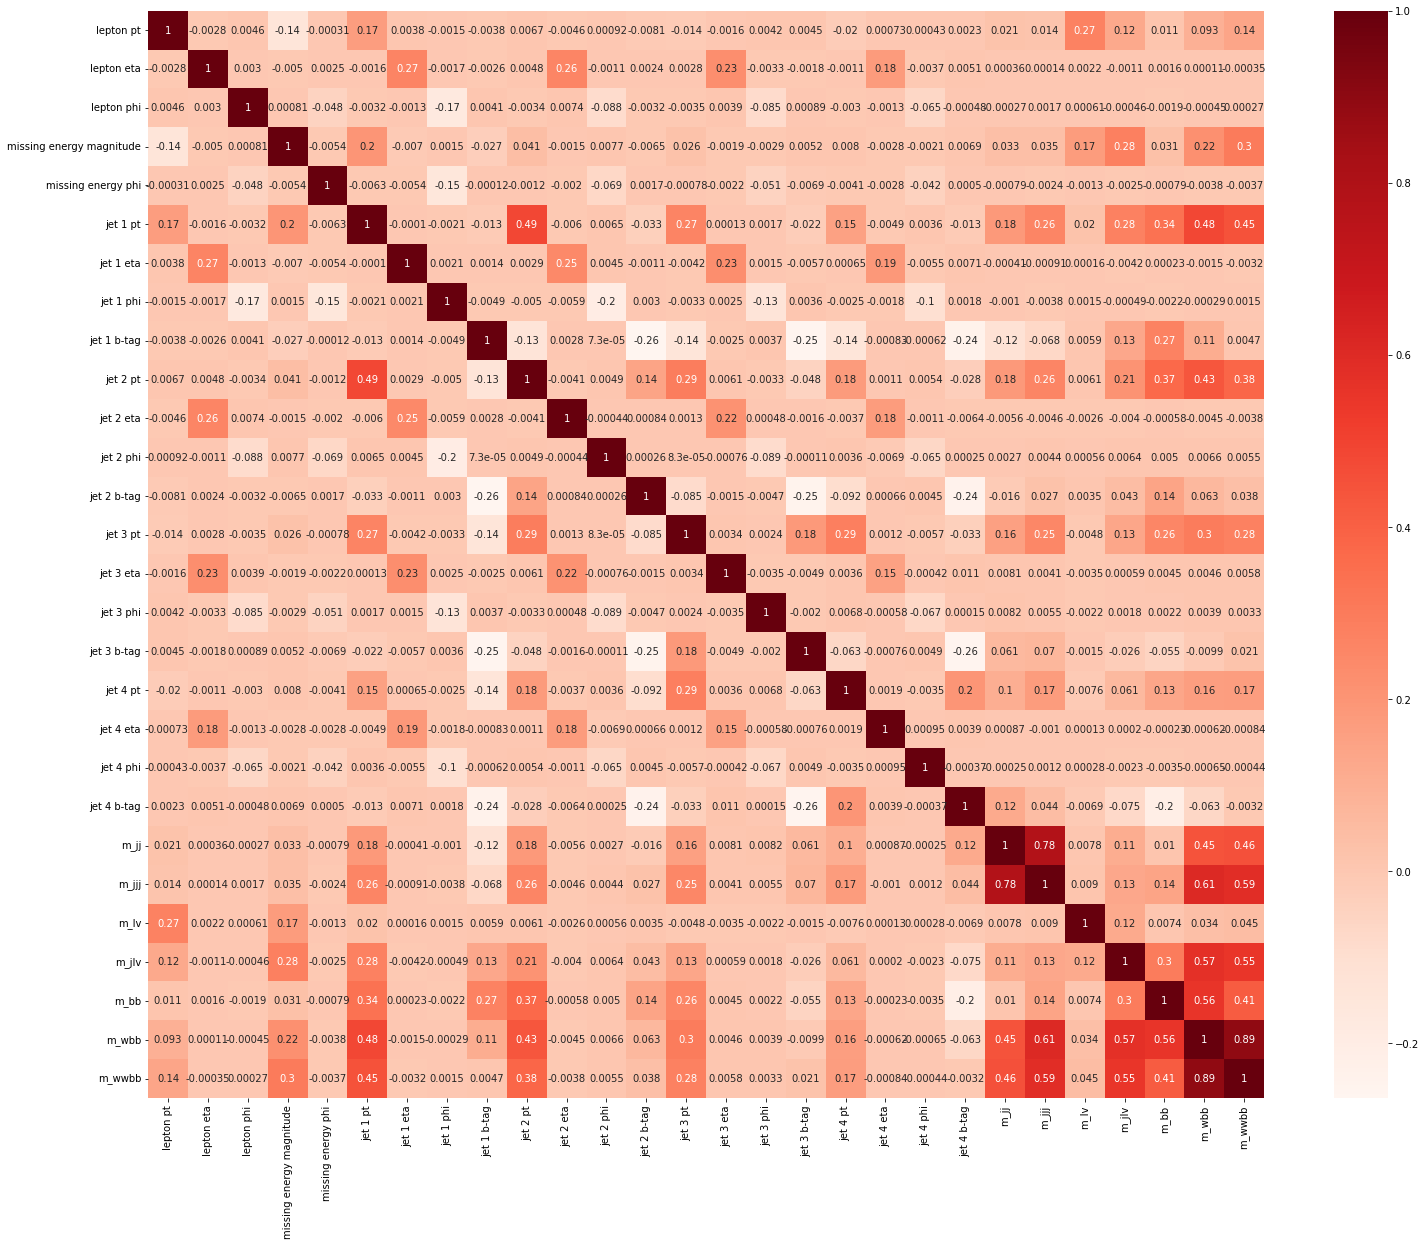

In [192]:
# Load the dataset using pandas and numpy 

import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split  

import matplotlib as mpl
#mpl.rcParams.update(style.style)
import matplotlib.pyplot as plt
import seaborn as sns


filename='/Users/cfanelli/Desktop/repositories/data/HIGGS.csv' 

features = [ "HIGGS", "lepton pt", "lepton eta", "lepton phi", "missing energy magnitude", \
            "missing energy phi", "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", \
            "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta", \
            "jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag",\
            "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"]

# if you want to train on subset 
subset_feat = ["HIGGS", "lepton pt", "lepton eta", "lepton phi", "missing energy magnitude", \
            "missing energy phi", "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag", \
            "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta", \
            "jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag"]

N = 100000
df = pd.read_csv(filename, header=None,nrows=N,engine='python')
df.columns = features 

"""
threshold_pt = 0.020 
condl = df['lepton pt'] >= threshold_pt
cond1 = df['jet 1 pt'] >= threshold_pt
cond2 = df['jet 2 pt'] >= threshold_pt
cond3 = df['jet 3 pt'] >= threshold_pt
cond4 = df['jet 4 pt'] >= threshold_pt

cond = condl & cond1 & cond2 & cond3 & cond4

check_pt = cond.all()
print(check_pt)
""" 

#b_tag: how likely jet is b; ideally 2 jets  
#b_tagging = df[["jet 1 b-tag", "jet 2 b-tag", "jet 3 b-tag", "jet 4 b-tag"]]

subset_feat = features #comment if you want to train on subset_feat
sub_df = df[subset_feat]

sub_df.head()

y = sub_df['HIGGS'].values
X = sub_df[[col for col in sub_df.columns if col!="HIGGS"]]

plt.rcParams["figure.figsize"] = (25,20)
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


## Training

In [197]:
# Training Dataset 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)


In [198]:
# Training Phase

from sklearn.metrics import roc_auc_score
import time
import xgboost as xgb
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


model = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000, use_label_encoder=False, eval_metric='logloss')

start_time = time.time()
model.fit(X_train, y_train)
run_time = time.time() - start_time

print("Done training. Runtime: {:.2f} sec\n".format(run_time))

Done training. Runtime: 54.93 sec



In [248]:
# Make Predictions

y_pred= model.predict(X_test)

#Print Results
print("Model Accuracy with all features is: {:.2f}%".format(100*model.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))

# Compare the same with the total sample (i.e. ~training dataset)
y_all= model.predict(X)

#Print Results
print("Model Accuracy with all features over the entire dataset is: {:.2f}%".format(100*model.score(X, y)))
print("The AUC score with all features  over the entire dataset is {:.2f}".format(roc_auc_score(y,y_all)))



Model Accuracy with all features is: 71.45%
The AUC score with all features is 0.71
Run time with all features: 54.93 sec


Model Accuracy with all features over the entire dataset is: 96.16%
The AUC score with all features  over the entire dataset is 0.96


## Visualization

N.b.: invariant mass spectra --- last 7 features are standardized

0.9000000000000001
0.9000000000000001


,lepton pt,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
99995,1.541120,-0.948700,-0.762068,0.752259,-0.835360,0.554040,-0.258475,0.639910,1.086538,0.976885,...,0.111138,0.049226,0.000000,0.359801,0.921513,0.977563,1.157282,0.971256,0.962689,0.914845
99996,0.957321,-0.759750,1.210569,0.863929,-0.120751,0.505580,0.058398,-0.496662,1.086538,0.509909,...,1.127182,1.674563,0.000000,0.838526,0.731589,1.173853,0.848387,0.840251,0.702825,0.642653
99997,0.878993,-1.687942,-1.318039,0.407732,-1.481964,0.847367,-0.680313,1.462603,1.086538,0.594642,...,-1.756052,-0.869814,0.000000,0.841216,1.112265,1.003257,0.768167,0.911731,0.911673,0.805071
99998,1.090185,0.409987,1.036898,0.427749,-1.035207,1.191169,-0.537720,1.576804,2.173076,1.156927,...,0.301854,-0.435315,3.101961,0.986065,0.995841,0.989216,0.851650,1.313143,1.096304,0.963150
99999,1.395078,0.143119,-1.087772,0.581583,-0.127351,1.125120,-2.388460,1.306269,0.000000,1.018811,...,1.423667,-0.208356,0.000000,0.804638,0.679799,0.983816,0.728147,1.098247,1.488028,1.466187


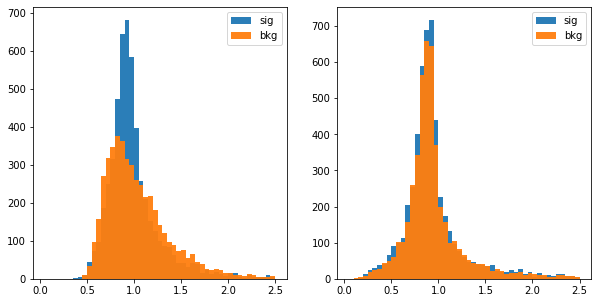

In [238]:
#https://www.thphys.uni-heidelberg.de/~gk_ppbsm/lib/exe/fetch.php?media=students:lectures:rtgneuralnetworks_lecture1.2_antel.pdf

#------------------------------------------#
# truth-matched dataframes with no selection 
#------------------------------------------#

# "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"

# M(h^{0})=125.3 GeV -> bb 
# M(W)=80.4 GeV      -> lv, jj
# M(H^{+})=325 GeV   -> Wh0-> bblv, bbjj
# M(H^{0})=425 GeV   -> bblvjj

#mis-match in the dataframe ?
# m_jlv -> m_lv
# 


sel_feature1 = "m_wbb"  #m_bb
sel_feature2 = "m_jj"

# filter HIGGS data (signal)  
sig_X = X_test[y_test==1] 

# filter HIGGS data (bkgd) 
bkg_X = X_test[y_test==0] 

#------------------------------------------#
# truth-matched dataframes after selection 
#------------------------------------------#

y_pred_test= model.predict(X_test)
# filter HIGGS data (signal)  
sig_X_pred = X_test[y_pred_test==1] 

# filter HIGGS data (bkgd) 
bkg_X_pred = X_test[y_pred_test==0] 


#------------------------------------------#
#                 PLOTS
#------------------------------------------#

#plt.rcParams["figure.figsize"] = (10,6)




# "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"



column1 = X_test[sel_feature1]
max_value1 = 2.500 #column1. max() 
min_value1 = 0.050#column1. min() 
#max_value = column. max() 
#min_value = column. min() 


bins1 = np.linspace(min_value1, max_value1, 50) 
#bins =50


plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
n_S1, bins_S1, patches_S1 = plt.hist(sig_X[sel_feature1], bins1, alpha=0.95, label='sig')
n_B1, bins_B1, patches_B1 = plt.hist(bkg_X[sel_feature1], bins1, alpha=0.95, label='bkg')
plt.legend(loc='upper right',prop={'size': 10})
#plt.show()

plt.subplot(1, 2, 2)
n_S2, bins_S2, patches_S2 = plt.hist(sig_X[sel_feature2], bins1, alpha=0.95, label='sig')
n_B2, bins_B2, patches_B2 = plt.hist(bkg_X[sel_feature2], bins1, alpha=0.95, label='bkg')
plt.legend(loc='upper right',prop={'size': 10})
#plt.show()

mode_index1 = np.argmax(n_S1,axis=0) #0 finds column indices
mode1 = bins_S1[mode_index1]
print(mode1)

mode_index2 = np.argmax(n_S2,axis=0) #0 finds column indices
mode2 = bins_S2[mode_index2]
print(mode2)

X.head()
X.tail()

## Feature Importance

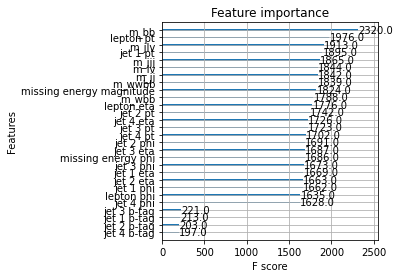

In [243]:
#magic function to render figure in a notebook 
%matplotlib inline

fig=plt.figure()
xgb.plot_importance(model, ax=plt.gca())
fig.subplots_adjust(left=0.4)  #

# Importance as F score (https://en.wikipedia.org/wiki/F-score)

## ROC curve 

0.7136210098280957


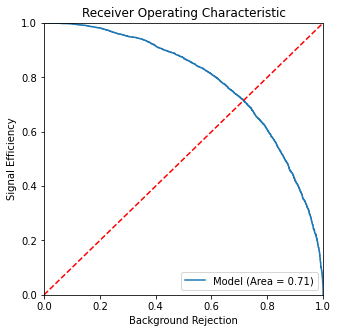

In [256]:
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, model.predict(X_test)) 
print(logit_roc_auc)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# Decreasing thresholds on the decision function used to compute fpr and tpr.
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1]) 
bkgd_rejection    = 1-fpr
signal_efficiency = tpr 

#print("shape of eff(S):", np.shape(signal_efficiency), ", shape of rej(B): ", np.shape(bkgd_rejection)


plt.figure(figsize=(5,5))
plt.plot(bkgd_rejection, signal_efficiency, label='Model (Area = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Background Rejection') # background rejection 
plt.ylabel('Signal Efficiency')  # signal efficiency 
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./images/XGBoost_ROC')
plt.show()


## Tune probability cut (output) to select point in the ROC curve

In [284]:
tmpy_pred = model.predict(X_test) 
tmpy_prob = model.predict_proba(X_test)[:,1] 

N = len(y_test)
threshold_value = 0.5   #you can tune this cut 

mask = [tmpy_prob>threshold_value]
anti_mask = np.invert(mask)

mask_true_sig  = [y_test==1]
mask_true_sig  = mask_true_sig[0].astype(int)
mask_true_bkgd = [y_test==0]
mask_true_bkgd = mask_true_bkgd[0].astype(int)


N_sig = mask_true_sig.sum()
N_bkgd = mask_true_bkgd.sum()

print("N: ", N, ", N_sig: ", N_sig, ", N_bkgd: ", N_bkgd)

anti_y_test = [not Elem for Elem in y_test]

true_sig    = np.logical_and(mask,y_test) #element wise
true_bkgd   = np.logical_and(anti_mask,anti_y_test)

tmp_S_eff = true_sig.sum()/N_sig
tmp_B_rej = true_bkgd.sum()/N_bkgd

print("\n\n*******************************************")
print("          sig. efficiency: {:.3f}".format(tmp_S_eff))
print("          bkgd. rejection: {:.3f}".format(tmp_B_rej))
print("*******************************************\n\n")

# Let's retrieve this from the calculated ROC curve 

# find index of list closest to value 
a = thresholds
idx_found = min(range(len(a)), key=lambda i: abs(a[i]-threshold_value))

print("\n\n*******************************************")
print("          sig. efficiency: {:.3f}".format(signal_efficiency[idx_found]))
print("          bkgd. rejection: {:.3f}".format(bkgd_rejection[idx_found]))
print("          (index: {:d})".format(idx_found))
print("*******************************************\n\n")



N:  10000 , N_sig:  5239 , N_bkgd:  4761


*******************************************
          sig. efficiency: 0.732
          bkgd. rejection: 0.695
*******************************************




*******************************************
          sig. efficiency: 0.732
          bkgd. rejection: 0.695
          (index: 1989)
*******************************************




## Optimizing XGBoost 

We will now optimize the parameters of the XGBoost algorithm by performing a grid search. We will use the very useful new function from scikit-learn **GridSearchCV()**. This function allows you <u>to specify lists of parameters to search over</u>.

Let us briefly discuss what parameters we can tune to improve performance with descriptions:

- **max_depth [default=6]**: maximum depth of a tree, increasing this value will make the model more complex / likely to overfit.
- **eta or 'learning_rate'[default =0.3]**: step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features. *eta* actually shrinks the feature weights to make the boosting process more conservative.
- **gamma or min-split-loss [default=0]**: This is the penalty that regularizes the number of leaves. The larger, the more conservative the algorithm will be.
- **min_child_weight [default=1]**: In linear regression mode, this simply corresponds to the minimum number of instances needed to be in each node (min  *Bj*
  in notation of manuscript). The larger, the more conservative the algorithm will be. More generally, it is the minimum sum of instance weight (Hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.

As you can see this cross-validation procedure is quite computationally expensive. With the parameters below, it takes somewhere between 2 and 5 minutes on a powerful laptop. In the cell below, we perform the search and examine the results in the subsequent results.

In [287]:
from sklearn.model_selection import GridSearchCV 

#Create values to search over
cv_params = {'max_depth': [3,4,6], 'min_child_weight': [1,3,5], 'learning_rate':[0.05,0.1]}
ind_params = {'n_estimators': 100, 'seed':1, 'colsample_bytree': 1, 
             'objective': 'binary:logistic', 'use_label_encoder': False}

# XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000, use_label_encoder=False, eval_metric='logloss')
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://xgboost.readthedocs.io/en/latest/python/python_api.html

opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, \
                                 scoring = 'accuracy', cv = 5, n_jobs = -1, verbose=3)

opt_XGBclassifier.fit(X_train, y_train)
opt_XGBclassifier.cv_results_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[17:21:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'mean_fit_time': array([27.60860858, 27.57445107, 27.54598055, 39.63967562, 39.24342251,
        39.17803679, 82.34267011, 80.63739944, 79.28816638, 27.68958802,
        32.86638184, 33.13180299, 47.05864239, 43.60200973, 42.18201275,
        73.67652068, 63.96831098, 56.40551052]),
 'std_fit_time': array([0.10279463, 0.10358678, 0.09983193, 0.41286245, 0.14418259,
        0.17624913, 0.62081503, 0.63632151, 1.11626259, 1.16018226,
        0.67145721, 0.10574401, 0.27748056, 1.40119149, 0.13928243,
        1.51518031, 5.33337766, 0.07883762]),
 'mean_score_time': array([0.03784304, 0.03647375, 0.03049841, 0.04601722, 0.03735046,
        0.04349456, 0.06899137, 0.04685779, 0.05273857, 0.05210924,
        0.05300331, 0.03941498, 0.05671163, 0.0433815 , 0.04353943,
        0.04691696, 0.03637061, 0.02692475]),
 'std_score_time': array([0.00624041, 0.0082725 , 0.00387492, 0.00684941, 0.00578202,
        0.00854934, 0.03518417, 0.00814224, 0.01069945, 0.01163804,
        0.01912621, 0.0045

In [288]:
#Print scores
print('The optimal score on training set is {:0.3f}'.format(opt_XGBclassifier.best_score_))

#Find optimal parameters

print('The optimal parameters for the classifier are:')
print(opt_XGBclassifier.best_params_)

#Fit performance on the test set
XGBclassifier_final=opt_XGBclassifier.best_estimator_
y_pred_final=XGBclassifier_final.predict(X_test)
print("Model Accuracy with optimal parameters: {:.2f}%".format(100*XGBclassifier_final.score(X_test, y_test)))
print("The  AUC score is {:.2f}".format(roc_auc_score(y_test,y_pred_final)))

The optimal score on training set is 0.726
The optimal parameters for the classifier are:
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5}
Model Accuracy with optimal parameters: 72.06%
The  AUC score is 0.72


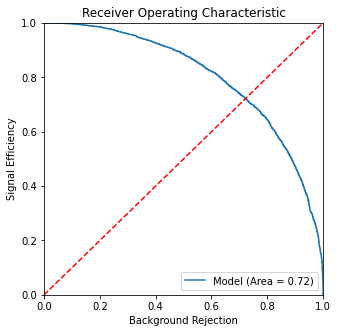

[17:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END learning_rate=0.1, max_depth=3, min_child_weight=5;, score=0.708 total time=  27.8s
[17:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END learning_rate=0.1, max_depth=4, min_child_weight=5;, score=0.715 total time=  42.3s
[17:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

[17:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END learning_rate=0.1, max_depth=3, min_child_weight=1;, score=0.710 total time=  27.8s
[17:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END learning_rate=0.1, max_depth=4, min_child_weight=3;, score=0.721 total time=  42.6s
[17:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

[17:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.1, max_depth=3, min_child_weight=1;, score=0.715 total time=  27.8s
[17:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END learning_rate=0.1, max_depth=4, min_child_weight=5;, score=0.716 total time=  41.8s
[17:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

[17:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END learning_rate=0.1, max_depth=3, min_child_weight=3;, score=0.708 total time=  27.7s
[17:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.1, max_depth=4, min_child_weight=3;, score=0.721 total time=  42.0s
[17:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

[17:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END learning_rate=0.1, max_depth=3, min_child_weight=5;, score=0.710 total time=  27.7s
[17:03:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END learning_rate=0.1, max_depth=4, min_child_weight=1;, score=0.715 total time=  42.2s
[17:04:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

[17:05:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END learning_rate=0.3, max_depth=4, min_child_weight=3;, score=0.726 total time=  45.2s
[17:06:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END learning_rate=0.3, max_depth=6, min_child_weight=3;, score=0.717 total time= 1.3min
[17:10:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

[17:02:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END learning_rate=0.1, max_depth=3, min_child_weight=3;, score=0.710 total time=  27.7s
[17:03:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END learning_rate=0.1, max_depth=4, min_child_weight=5;, score=0.715 total time=  42.4s
[17:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

In [290]:
logit_roc_auc = roc_auc_score(y_test, XGBclassifier_final.predict(X_test)) 


fpr, tpr, thresholds = roc_curve(y_test, XGBclassifier_final.predict_proba(X_test)[:,1]) 
bkgd_rejection    = 1-fpr
signal_efficiency = tpr 

#print("shape of eff(S):", np.shape(signal_efficiency), ", shape of rej(B): ", np.shape(bkgd_rejection)


plt.figure(figsize=(5,5))
plt.plot(bkgd_rejection, signal_efficiency, label='Model (Area = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Background Rejection') # background rejection 
plt.ylabel('Signal Efficiency')  # signal efficiency 
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./images/optimal_XGBoost_ROC')
plt.show()